In [15]:
%matplotlib inline
import sys
from datetime import datetime as dt

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import lightgbm as lgb
from statsmodels.stats.outliers_influence import variance_inflation_factor

sys.path.append('../')
from util.feature import add_feature, fillna
from util.metric import mean_square_error
from util import variables

sns.set(style='white')
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

In [2]:
train_data = pd.read_csv('../data/d_train_20180102.csv')
test_data = pd.read_csv('../data/d_test_A_20180102.csv')
test_data['血糖'] = -1
data = pd.concat([train_data, test_data], ignore_index=True)
data = fillna(data)
data = add_feature(data)

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1023: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['性别']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:662: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


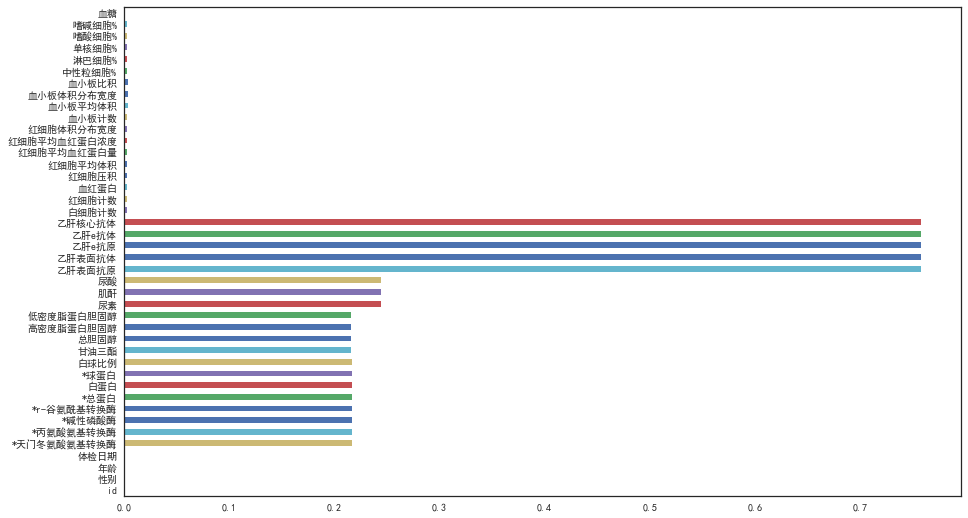

In [3]:
na_data = train_data.isna().sum() / train_data.shape[0]
fig_na, ax_na = plt.subplots(figsize=(15,9))
na_data.plot.barh(ax=ax_na)

In [4]:
data

,id,性别,年龄,体检日期,*天门冬氨酸氨基转换酶,*丙氨酸氨基转换酶,*碱性磷酸酶,*r-谷氨酰基转换酶,*总蛋白,白蛋白,...,白蛋白/总蛋白,球蛋白/总蛋白,甘油三酯/总胆固醇,高低固醇比例,尿素酸比例,白红细胞比例,嗜碱酸细胞比例,年龄段,eGFR,GFR
0,1,0.0,41.0,2017-10-12,24.960000,23.100000,99.590000,20.230000,76.880000,49.600000,...,0.645161,0.354839,0.295711,0.516981,0.016801,1.024952,0.127660,8.0,5.459373,0.545768
1,2,0.0,41.0,2017-10-19,24.570000,36.250000,67.210000,79.000000,79.430000,47.760000,...,0.601284,0.398716,0.692118,0.353612,0.010806,1.468330,0.170213,8.0,5.417919,0.475058
2,3,0.0,46.0,2017-10-26,20.820000,15.230000,63.690000,38.170000,86.230000,48.000000,...,0.556651,0.443349,0.239709,0.815920,0.010551,0.966387,0.250000,9.0,5.271029,0.525777
3,4,1.0,22.0,2017-10-25,14.990000,10.590000,74.080000,20.220000,70.980000,44.020000,...,0.620175,0.379825,0.153846,0.283730,0.011468,2.181818,0.108696,4.0,5.154785,0.590203
5,6,1.0,74.0,2017-10-18,23.720000,22.590000,81.230000,23.350000,76.460000,45.850000,...,0.599660,0.400340,0.368421,0.422897,0.015917,1.508621,0.476190,14.0,3.584529,0.420102
6,7,0.0,31.0,2017-09-21,24.970000,25.530000,109.030000,65.420000,80.820000,46.400000,...,0.574115,0.425885,0.269643,0.348168,0.013764,1.129353,0.225806,6.0,5.770732,0.449630
7,8,0.0,55.0,2017-09-21,37.320000,40.030000,88.490000,25.150000,74.170000,41.630000,...,0.561278,0.438722,0.222973,0.304762,0.018304,1.179592,0.321429,10.0,4.905742,0.419433
8,9,0.0,39.0,2017-10-16,21.700000,39.170000,102.910000,67.090000,76.120000,49.310000,...,0.647793,0.352207,0.376364,0.419444,0.014095,1.408907,0.121212,7.0,5.528543,0.540662
9,10,1.0,35.0,2017-10-10,18.890000,15.790000,78.210000,25.750000,75.940000,46.640000,...,0.614169,0.385831,0.314070,0.767327,0.024801,1.852391,0.700000,7.0,4.599909,0.360238
10,11,0.0,47.0,2017-10-13,27.330000,35.760000,80.260000,84.970000,75.840000,43.710000,...,0.576345,0.423655,0.453704,0.316901,0.016787,1.094567,0.692308,9.0,5.296499,0.631163


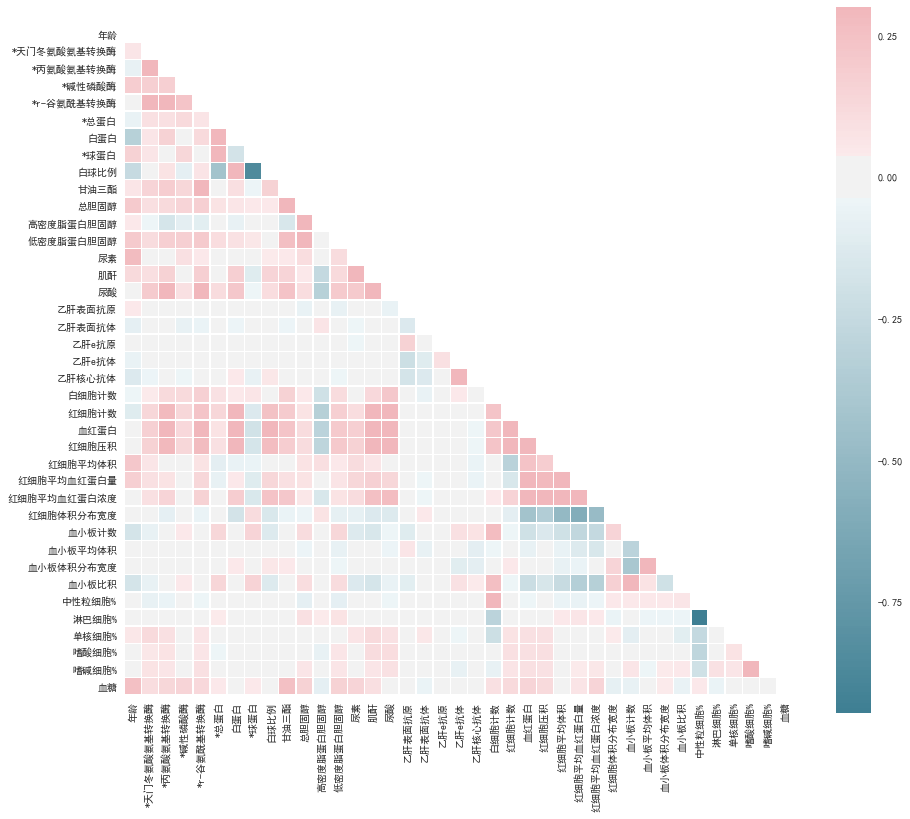

In [5]:
corr = train_data.loc[:, '年龄':].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig_corr, ax_corr = plt.subplots(figsize=(15, 13))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
           square=True, linewidth=.5, ax=ax_corr)

(-50, 810)

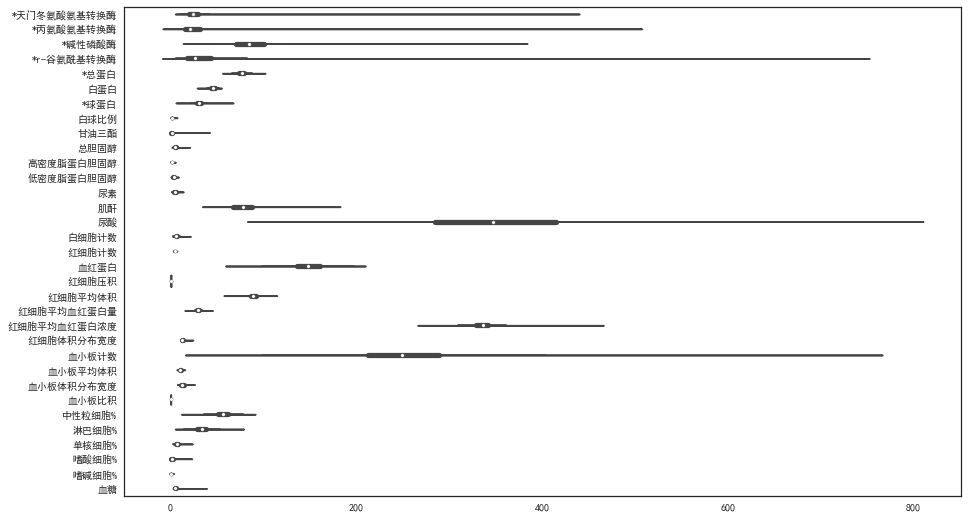

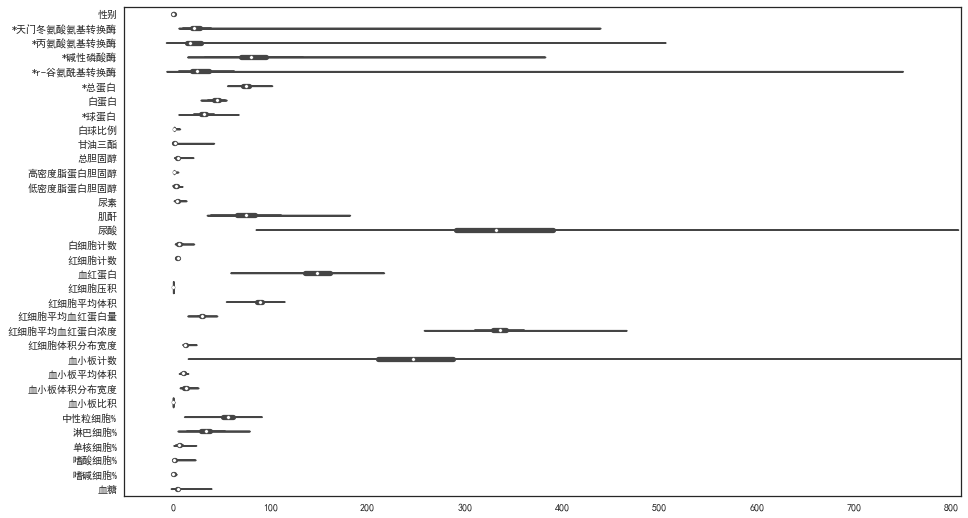

In [6]:
fig_boxt, ax_boxt = plt.subplots(figsize=(15, 9))
XTrain = train_data.loc[:, [column for column in train_data.columns if column not in 
                        ['id', '年龄', '体检日期', '乙肝表面抗原',
                         '乙肝表面抗体', '乙肝e抗原', '乙肝e抗体', '乙肝核心抗体',
                         'dayofyear']]]
sns.violinplot(data=XTrain, orient="h", ax=ax_boxt)

fig_boxa, ax_boxa = plt.subplots(figsize=(15, 9))
XALL = data.loc[:, [column for column in train_data.columns if column not in 
                    ['id', '年龄', '体检日期', '乙肝表面抗原',
                     '乙肝表面抗体', '乙肝e抗原', '乙肝e抗体', '乙肝核心抗体',
                     'dayofyear']]]
sns.violinplot(data=XALL, orient="h", ax=ax_boxa)
ax_boxa.set_xlim(left=-50, right=810)

feature = data.loc[:, [column for column in data.columns if column not in ['id', '性别', '血糖', '体检日期']]]
scaler = MinMaxScaler()
scaler.fit(feature)
feature = scaler.transform(feature)

X_embedded = TSNE(n_components=2).fit_transform(feature)

fig_embed, ax_embed = plt.subplots()
ax_embed.scatter(X_embedded[:, 0], X_embedded[:, 1], linewidths=0.01, c=data['血糖']>0.0, alpha=0.3)

k = KMeans(n_clusters=2, random_state=0).fit_predict(X_embedded)

fig_kmeans, ax_kmeans = plt.subplots()
ax_kmeans.scatter(X_embedded[:, 0], X_embedded[:, 1], linewidths=0.01, c=data['性别'], alpha=0.3)

D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


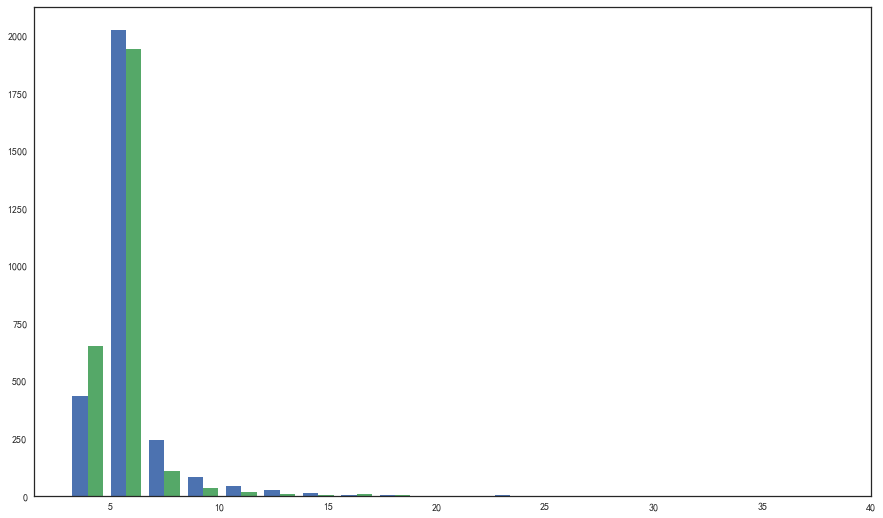

In [7]:
fig_gluhist, ax_gluhist = plt.subplots(figsize=(15, 9))
n, bins, pathes = ax_gluhist.hist([train_data.loc[train_data['性别'] == '男', '血糖'], 
                                   train_data.loc[train_data['性别'] == '女', '血糖']],
                                   bins=20)


33


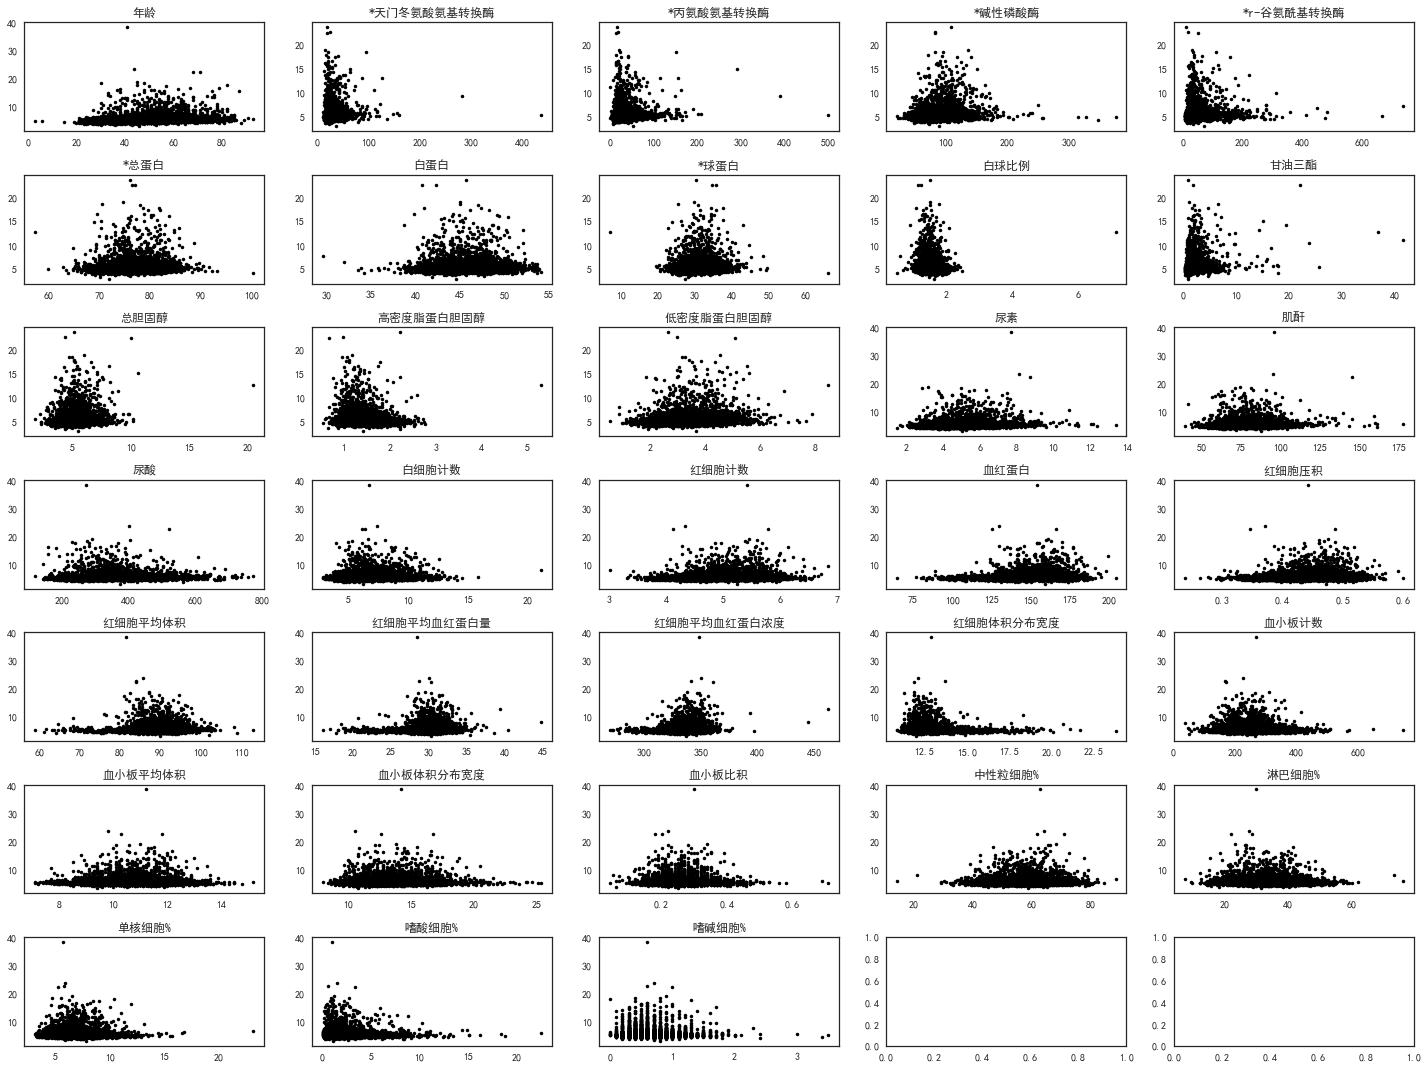

In [8]:
origin_feature = [column for column in train_data.columns if column not in ['id', '性别', '血糖', '体检日期', '乙肝表面抗原',
                         '乙肝表面抗体', '乙肝e抗原', '乙肝e抗体', '乙肝核心抗体']]
print(len(origin_feature))
fig_f2o, ax_f2o = plt.subplots(7, 5, figsize=(20, 15))
for idx, col in enumerate(origin_feature):
    ax_f2o[idx//5, idx%5].plot(train_data[col], train_data['血糖'], 'k.')
    ax_f2o[idx//5, idx%5].set_title(col)
fig_f2o.tight_layout()

In [9]:
train = fillna(train_data)
train = add_feature(train)

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1023: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['性别']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:662: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


In [13]:
XALL = train.loc[:, [column for column in train.columns if column not in ['id', '体检日期', '血糖', '性别']]]
yALL = train.loc[:, '血糖']
feature_col = XALL.columns
scaler = StandardScaler()
XALL = scaler.fit_transform(XALL)
XALL = pd.DataFrame(XALL, columns=feature_col)

all_set = lgb.Dataset(XALL, label=yALL)
gbm = lgb.train(variables.lgb_params, all_set,
                num_boost_round=10000,
                early_stopping_rounds=variables.early_stopping_rounds,
                valid_sets=[all_set],
                verbose_eval=100,
                feval=mean_square_error)
glu = gbm.predict(XALL)

Training until validation scores don't improve for 300 rounds.
[100]	training's l2: 1.77733	training's mse: 0.888775
[200]	training's l2: 1.45176	training's mse: 0.725917
[300]	training's l2: 1.24775	training's mse: 0.62393
[400]	training's l2: 1.0978	training's mse: 0.548867
[500]	training's l2: 0.979471	training's mse: 0.48977
[600]	training's l2: 0.895536	training's mse: 0.447816
[700]	training's l2: 0.830468	training's mse: 0.415253
[800]	training's l2: 0.772936	training's mse: 0.386452
[900]	training's l2: 0.720266	training's mse: 0.360155
[1000]	training's l2: 0.675631	training's mse: 0.337815
[1100]	training's l2: 0.636354	training's mse: 0.318226
[1200]	training's l2: 0.601592	training's mse: 0.300788
[1300]	training's l2: 0.568874	training's mse: 0.284426
[1400]	training's l2: 0.540241	training's mse: 0.27008
[1500]	training's l2: 0.512508	training's mse: 0.256276
[1600]	training's l2: 0.488996	training's mse: 0.244583
[1700]	training's l2: 0.466769	training's mse: 0.233366
[1

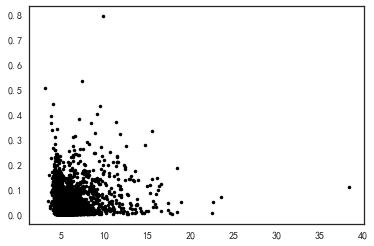

In [11]:
mse_loss = (glu - yALL)**2
fig_loss, ax_loss = plt.subplots()
ax_loss.plot(yALL, mse_loss, 'k.', lw=0.1)

[Text(0,0.5,'Features'),
 Text(0.5,0,'VIF Scores'),
 Text(0.5,1,'Variables Which Exhibit Multicollinearity')]

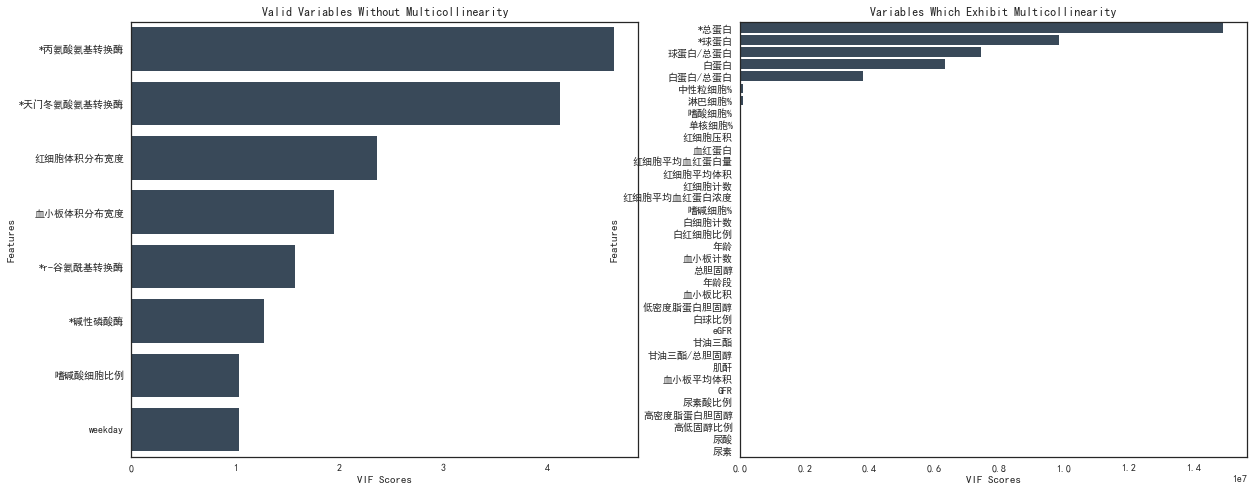

In [23]:
def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

vif_dict = calculate_vif_(XALL)

vif_df = pd.DataFrame()
vif_df['variables'] = vif_dict.keys()
vif_df['vif_score'] = vif_dict.values()
vif_df.sort_values(by=['vif_score'], ascending=False, inplace=True)
valid_var = vif_df[vif_df['vif_score'] <= 5]
var_with_MC = vif_df[vif_df['vif_score'] > 5]

fig_collinear,ax_collinear = plt.subplots(ncols=2)
fig_collinear.set_size_inches(20,8)
sns.barplot(data=valid_var,x="vif_score",y="variables",ax=ax_collinear[0],orient="h",color="#34495e")
sns.barplot(data=var_with_MC,x="vif_score",y="variables",ax=ax_collinear[1],orient="h",color="#34495e")
ax_collinear[0].set(xlabel='VIF Scores', ylabel='Features',title="Valid Variables Without Multicollinearity")
ax_collinear[1].set(xlabel='VIF Scores', ylabel='Features',title="Variables Which Exhibit Multicollinearity")